In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd 'drive/MyDrive/Robot-Manipulation-Project'

[Errno 2] No such file or directory: 'drive/MyDrive/Robot-Manipulation-Project'
/content/drive/MyDrive/Robot-Manipulation-Project


In [ ]:
import cv2

def yolo_to_absolute(image, line):
    """Convert YOLO format to absolute pixel values."""
    height, width = image.shape[:2]

    # Parsing YOLO format data
    class_id, x_center, y_center, box_width, box_height = map(float, line.split())
    class_id = int(class_id)

    # Convert YOLO center coordinates (relative values between 0 and 1) to absolute pixel values
    x_center_abs = int(x_center * width)
    y_center_abs = int(y_center * height)

    # Convert YOLO box dimensions (relative values between 0 and 1) to absolute pixel values
    box_width_abs = int(box_width * width)
    box_height_abs = int(box_height * height)

    # Calculate top-left and bottom-right coordinates for the bounding box
    x1 = int(x_center_abs - (box_width_abs / 2))
    y1 = int(y_center_abs - (box_height_abs / 2))
    x2 = int(x_center_abs + (box_width_abs / 2))
    y2 = int(y_center_abs + (box_height_abs / 2))

    return class_id, (x1, y1, x2, y2)

def draw_boxes_on_image(image_path, annotations_path):
    # Read the image
    image = cv2.imread(image_path)

    # Read annotations from the txt file
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    print(annotations)

    # Loop over each line (annotation) in the YOLO formatted annotations
    for line in annotations:
        class_id, (x1, y1, x2, y2) = yolo_to_absolute(image, line.strip())
        # Draw bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color, thickness=2
        # You can also put class_id or some text on the image if needed using cv2.putText

    # Display the image
    # cv2.imshow("Image with Bounding Boxes", image)
    cv2.imwrite("bounding_box_image.jpg", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

# Sample usage
image_path = "images/000619_png_jpg.rf.75d5b762b01e8ea4c8dceb068e378522.jpg"
annotations_path = "labels/000619_png_jpg.rf.75d5b762b01e8ea4c8dceb068e378522.txt"
draw_boxes_on_image(image_path, annotations_path)


['13 0.159375 0.5864583333333333 0.115625 0.33541666666666664\n', '3 0.58203125 0.13229166666666667 0.1390625 0.20625\n', '15 0.6984375 0.184375 0.078125 0.08541666666666667\n', '14 0.59609375 0.48541666666666666 0.8078125 0.5708333333333333\n', '17 0.30546875 0.7520833333333333 0.0796875 0.0125']


In [ ]:
!pip install torch torchvision

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image

# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(img_dir)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        label_path = os.path.join(self.label_dir, self.imgs[idx].replace('.jpg', '.txt'))

        img = Image.open(img_path).convert("RGB")

        # Read labels
        with open(label_path, 'r') as f:
            boxes = []
            labels = []
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.split())
                class_id = int(class_id)
                # Convert YOLO format to [x_min, y_min, x_max, y_max]
                img_width, img_height = img.size
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                x_max = (x_center + width / 2) * img_width
                y_max = (y_center + height / 2) * img_height
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Define transformations
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
dataset = CustomDataset(img_dir="images", label_dir="labels", transforms=data_transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Load the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 21  # Assuming 20 classes + 1 background class
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Iteration {i}/{len(data_loader)} of epoch {epoch}/{num_epochs}, Loss: {losses.item()}")
        i += 1

print("Training complete!")

# Save the model
torch.save(model.state_dict(), "fasterrcnn_resnet50_fpn_custom.pth")

Iteration 0/80 of epoch 0/10, Loss: 4.264184474945068
Iteration 1/80 of epoch 0/10, Loss: 3.158935785293579
Iteration 2/80 of epoch 0/10, Loss: 6.242888450622559
Iteration 3/80 of epoch 0/10, Loss: 3.5174167156219482
Iteration 4/80 of epoch 0/10, Loss: 2.2590341567993164
Iteration 5/80 of epoch 0/10, Loss: 2.852787733078003
Iteration 6/80 of epoch 0/10, Loss: 2.2462217807769775
Iteration 7/80 of epoch 0/10, Loss: 2.5731441974639893
Iteration 8/80 of epoch 0/10, Loss: 2.109914779663086
Iteration 9/80 of epoch 0/10, Loss: 2.2977802753448486
Iteration 10/80 of epoch 0/10, Loss: 1.7645845413208008
Iteration 11/80 of epoch 0/10, Loss: 1.1283906698226929
Iteration 12/80 of epoch 0/10, Loss: 2.156068801879883
Iteration 13/80 of epoch 0/10, Loss: 1.34258234500885
Iteration 14/80 of epoch 0/10, Loss: 1.9473717212677002
Iteration 15/80 of epoch 0/10, Loss: 2.318955898284912
Iteration 16/80 of epoch 0/10, Loss: 2.342111587524414
Iteration 17/80 of epoch 0/10, Loss: 1.6623355150222778
Iteration 18

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import cv2
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def load_model(model_path, num_classes):
    # Create the model and load the trained weights
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(f"model_path: {model_path}")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(image_path, model, device, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)

    # Extract bounding boxes with score above threshold
    boxes = prediction[0]['boxes'][prediction[0]['scores'] > threshold].cpu().numpy()
    labels = prediction[0]['labels'][prediction[0]['scores'] > threshold].cpu().numpy()
    scores = prediction[0]['scores'][prediction[0]['scores'] > threshold].cpu().numpy()

    return boxes, labels, scores

def draw_boxes(image_path, boxes, labels, scores):
    image = cv2.imread(image_path)
    for box, label, score in zip(boxes, labels, scores):
        color = (0, 255, 0)
        cv2.rectangle(image, (int(box[0]), int(box[1]), int(box[2]), int(box[3])), color, 2)
        text = f"Class: {label}, Score: {score:.2f}"
        cv2.putText(image, text, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # cv2.imshow("Predictions", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    cv2.imwrite("inference/bounding_box_predicted.jpg", image)

if __name__ == "__main__":
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load the model
    num_classes = 21  # Assuming 20 classes + 1 background class
    model_path = "fasterrcnn_resnet50_fpn_custom.pth"
    model = load_model(model_path, num_classes)
    model.to(device)

    # Provide path to your test image
    image_path = "images/000619_png_jpg.rf.75d5b762b01e8ea4c8dceb068e378522.jpg"

    # Get predictions
    boxes, labels, scores = predict(image_path, model, device)

    # Draw bounding boxes
    draw_boxes(image_path, boxes, labels, scores)

model_path: fasterrcnn_resnet50_fpn_custom.pth


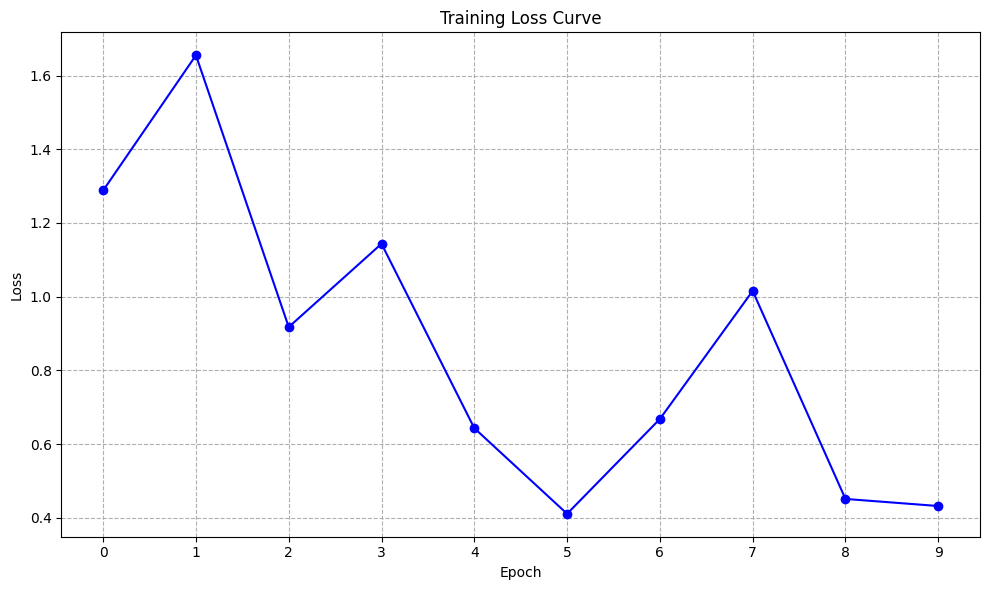

In [ ]:
import matplotlib.pyplot as plt

# Read the data from the file
loss_values = []
with open("training_loss_epoch.txt", "r") as file:
    for line in file.readlines():
        # Extract the loss value from each line
        loss = float(line.split(":")[1].strip())
        loss_values.append(loss)

# Data
epochs = [i for i in range(len(loss_values))]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.grid(True, linestyle='--')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import re
import matplotlib.pyplot as plt

# Read the file
with open('training_loss.txt', 'r') as file:
    lines = file.readlines()

# Extract loss values and epoch numbers
losses = [float(re.search(r"Loss: (\d+\.\d+)", line).group(1)) for line in lines]
epochs = [int(re.search(r"epoch (\d+)/", line).group(1)) for line in lines]

# Visualizing Loss vs. Iterations
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
# plt.show()
plt.savefig("loss_vs_iterations.jpg")
plt.close()

# Calculating Average Loss for Each Epoch
unique_epochs = list(set(epochs))
average_losses = [sum([losses[i] for i in range(len(losses)) if epochs[i] == epoch]) / epochs.count(epoch) for epoch in unique_epochs]

plt.figure(figsize=(15, 5))
plt.plot(unique_epochs, average_losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss vs. Epochs')
# plt.show()
plt.savefig("loss_vs_epochs.jpg")
plt.close()
